In [1]:
import numpy as np
import pandas

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import csv

In [2]:
uci_base = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'
url = '{}{}'.format(uci_base, '00294/CCPP.zip')

with urlopen(url) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('/tmp')
data = pandas.read_excel('/tmp/CCPP//Folds5x2_pp.xlsx').values

In [3]:
X = data[:,:-1]
Y = data[:, -1, None]

ind = np.arange(X.shape[0])

np.random.seed(123)
np.random.shuffle(ind)
prop = 0.9
n = int(X.shape[0] * prop)

Xtrain = X[ind[:n], :]; Ytrain = Y[ind[:n], :]
Xtest = X[ind[n:], :]; Ytest = Y[ind[n:], :]

In [4]:
mi, ma = Xtrain.min(axis=0), Xtrain.max(axis=0)
print('Min:', mi)
print('Max:', ma)

Xtrain = (Xtrain - mi) / (ma - mi)
Xtest = (Xtest - mi) / (ma - mi)

mi = 0.01
ma = 0.99
Xtrain = Xtrain * (ma - mi) + mi
Xtest = Xtest * (ma - mi) + mi

mi, ma = Xtest.min(axis=0), Xtest.max(axis=0)
print('NewMin:', mi)
print('NewMax:', ma)

meany, stdy = np.average(Ytrain), np.std(Ytrain)
Ytrain = (Ytrain - meany) / stdy
#Ytest = (Ytest - meany) / stdy

print('Mean of Ytest:', Ytest.mean())
print('Ytest std:', Ytest.std())

Min: [  1.81  25.36 992.89  25.56]
Max: [  37.11   81.56 1033.3   100.16]
NewMin: [0.03137677 0.16118505 0.03255382 0.0441555 ]
NewMax: [0.9369745  0.96715658 0.98466469 0.98986863]
Mean of Ytest: 454.6950888192267
Ytest std: 17.133345182862584


In [5]:
from gpmaniflow.models.BezierProcess2 import BezierProcess
from gpflow.likelihoods import Gaussian
import gpflow
import tensorflow as tf

from gpflow.utilities import print_summary

2022-03-15 13:58:44.439112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 13:58:44.439136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
m = BezierProcess(input_dim = 4, orders = 8, likelihood = Gaussian(), num_data = Xtrain.shape[0])
print_summary(m)

hey
[8, 8, 8, 8]
[8, 8, 8, 8]
[0, 8, 8, 8, 8]
tf.Tensor(
[[1.        ]
 [2.15635523]
 [1.94473837]
 [2.43198726]
 [2.11469574]
 [2.43198726]
 [1.94473837]
 [2.15635523]
 [1.        ]], shape=(9, 1), dtype=float64)
╒═════════════════════════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                                            │ class            │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                                 │
╞═════════════════════════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════════════════════════╡
│ BezierProcess.likelihood.variance               │ Parameter        │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.0                                                   │
├─────────────────────────

2022-03-15 13:58:45.944319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 13:58:45.944345: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 13:58:45.944363: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martinj): /proc/driver/nvidia/version does not exist
2022-03-15 13:58:45.944651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
m.likelihood.variance.assign(0.06)
gpflow.set_trainable(m.likelihood.variance, False)
#gpflow.set_trainable(m.BN.varw, False)

2022-03-15 13:58:46.027216: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [8]:
m.BN.kl()

tf.Tensor([[-116.25589689]], shape=(1, 1), dtype=float64)
tf.Tensor([[-103.53441328]], shape=(1, 1), dtype=float64)
tf.Tensor([[-135.88583912]], shape=(1, 1), dtype=float64)
tf.Tensor([[-114.84085527]], shape=(1, 1), dtype=float64)
det_term: tf.Tensor([[-114.84085527]], shape=(1, 1), dtype=float64)
mean_term: tf.Tensor([[7.98960784e-09]], shape=(1, 1), dtype=float64)
trace_term: tf.Tensor([[6480.69802652]], shape=(1, 1), dtype=float64)


<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[17.2694409]])>

In [9]:
preds, predvar = m.predict_f(Xtest)
print(predvar)

tf.Tensor(
[[1.01400896]
 [0.96255957]
 [0.9895254 ]
 [0.9815543 ]
 [0.95908757]
 [0.99614911]
 [0.99847245]
 [0.9426444 ]
 [0.94418979]
 [0.8337274 ]
 [0.98948421]
 [0.99608448]
 [0.99151315]
 [1.00300046]
 [0.9420892 ]
 [0.98150108]
 [0.94537612]
 [0.81118718]
 [0.95971622]
 [0.98156605]
 [0.95617652]
 [0.96989026]
 [0.80398319]
 [1.01724628]
 [0.97352533]
 [0.87322412]
 [0.95745647]
 [0.80805576]
 [0.99628283]
 [0.98852354]
 [0.99299094]
 [0.9641384 ]
 [0.98590845]
 [0.94748625]
 [0.96307925]
 [0.97183651]
 [0.98380483]
 [0.9993879 ]
 [1.05779578]
 [1.02218684]
 [0.99012369]
 [0.96077548]
 [0.98372736]
 [0.99992151]
 [1.01820989]
 [0.92315295]
 [0.99545851]
 [0.97814943]
 [0.99000724]
 [0.98140343]
 [0.95950986]
 [0.98041342]
 [0.99244273]
 [1.05764981]
 [0.95664357]
 [0.88342614]
 [0.98569954]
 [0.96253245]
 [0.9181221 ]
 [0.93058562]
 [0.97674787]
 [0.94922227]
 [0.92831149]
 [1.10775737]
 [1.01838325]
 [0.99674825]
 [1.01719815]
 [0.83731943]
 [0.95111494]
 [1.00084266]
 [0.92708

In [10]:
minibatch_size = 500

train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).repeat().shuffle(Xtrain.shape[0])
train_iter = iter(train_dataset.batch(minibatch_size))

#m.predict_f(Xtrain[:3,:], approx = False)

training_loss = m.training_loss_closure(train_iter, compile=True)
optimizer = tf.optimizers.Adam(learning_rate = 0.01)

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, m.trainable_variables)

iterations = 5000
for step in range(iterations):
    optimization_step()
    if step % 100 == 0:
        elbo = -training_loss().numpy()
        print('Step:', step, 'Elbo:', elbo)

Tensor("add_1:0", shape=(1, 1), dtype=float64)
Tensor("add_2:0", shape=(1, 1), dtype=float64)
Tensor("add_3:0", shape=(1, 1), dtype=float64)
Tensor("add_4:0", shape=(1, 1), dtype=float64)
det_term: Tensor("add_4:0", shape=(1, 1), dtype=float64)
mean_term: Tensor("Sum:0", shape=(1, 1), dtype=float64)
trace_term: Tensor("Sum_1:0", shape=(1, 1), dtype=float64)


2022-03-15 13:58:48.250732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Step: 0 Elbo: [[-134124.39934081]]
Step: 100 Elbo: [[-11440.73302971]]
Step: 200 Elbo: [[-7826.93639348]]
Step: 300 Elbo: [[-6560.06635449]]
Step: 400 Elbo: [[-6845.8818906]]
Step: 500 Elbo: [[-5753.10454523]]
Step: 600 Elbo: [[-5941.30736399]]
Step: 700 Elbo: [[-5562.06031765]]
Step: 800 Elbo: [[-5660.05601095]]
Step: 900 Elbo: [[-5917.26352772]]
Step: 1000 Elbo: [[-6584.85659494]]
Step: 1100 Elbo: [[-5126.85729481]]
Step: 1200 Elbo: [[-5236.24991517]]
Step: 1300 Elbo: [[-5553.27044011]]
Step: 1400 Elbo: [[-5559.9554029]]
Step: 1500 Elbo: [[-5287.21132149]]
Step: 1600 Elbo: [[-5068.9843128]]
Step: 1700 Elbo: [[-6567.69966305]]
Step: 1800 Elbo: [[-5199.03773172]]
Step: 1900 Elbo: [[-5113.38545776]]
Step: 2000 Elbo: [[-6177.78119983]]
Step: 2100 Elbo: [[-4882.98490642]]
Step: 2200 Elbo: [[-5645.11148711]]
Step: 2300 Elbo: [[-6111.61881246]]
Step: 2400 Elbo: [[-6152.41244665]]
Step: 2500 Elbo: [[-5251.41946616]]
Step: 2600 Elbo: [[-5894.48536635]]
Step: 2700 Elbo: [[-5079.11822539]]
Step

In [11]:
preds, predvar = m.predict_f(Xtest)
RMSE = np.sqrt( ( (Ytest - (meany + stdy*preds.numpy()))**2).mean())
print('RMSE:', RMSE)
RMedSE = np.sqrt( np.median( (Ytest - (meany + stdy*preds.numpy()))**2))
print('RMedSE:', RMedSE)
print(preds)

RMSE: 3.99070103350723
RMedSE: 2.6470220681034107
tf.Tensor(
[[-0.58932606]
 [-1.16846693]
 [ 1.33454656]
 [-0.72769327]
 [-1.19652148]
 [-0.6166973 ]
 [ 1.34556429]
 [ 0.52510041]
 [ 0.28137647]
 [-0.98144849]
 [ 1.51078212]
 [-0.46285706]
 [ 0.78972551]
 [-0.62203964]
 [-1.23949554]
 [-1.36066322]
 [ 0.06525232]
 [ 1.53261854]
 [ 1.34079234]
 [-0.37873554]
 [ 1.32424462]
 [ 0.82129191]
 [ 0.17403268]
 [ 0.36076169]
 [-1.0538255 ]
 [-0.20246213]
 [-0.62810151]
 [ 0.68619011]
 [-0.51508895]
 [-0.98853917]
 [-0.35220018]
 [ 0.00414158]
 [-0.79995359]
 [ 1.24676838]
 [-1.29684524]
 [-0.57273592]
 [ 1.31653843]
 [ 1.59602478]
 [ 0.43855224]
 [-0.485199  ]
 [ 1.93211358]
 [-0.82566135]
 [-0.77712209]
 [-0.07679743]
 [ 0.44042087]
 [ 0.86163325]
 [ 1.7067145 ]
 [ 0.6195269 ]
 [-1.09589144]
 [ 1.5431269 ]
 [ 1.46668135]
 [-0.88323137]
 [-1.28577665]
 [ 0.41853367]
 [ 0.71543514]
 [ 1.8255633 ]
 [-0.62290026]
 [-1.36836062]
 [-1.23909879]
 [ 0.72983396]
 [ 0.19690737]
 [ 0.53076957]
 [ 0.7307

In [12]:
print(predvar)

tf.Tensor(
[[0.01598986]
 [0.0307286 ]
 [0.01231428]
 [0.02439989]
 [0.01916008]
 [0.01636661]
 [0.04278649]
 [0.02372569]
 [0.02079154]
 [0.03659235]
 [0.01576223]
 [0.01514651]
 [0.01809988]
 [0.01909326]
 [0.03743717]
 [0.03156514]
 [0.0185463 ]
 [0.07392126]
 [0.01345375]
 [0.02260222]
 [0.01418371]
 [0.02409263]
 [0.02555673]
 [0.02131917]
 [0.01167921]
 [0.03409409]
 [0.03626337]
 [0.06683113]
 [0.01845458]
 [0.01478699]
 [0.01398187]
 [0.02531032]
 [0.01087897]
 [0.02134208]
 [0.02954442]
 [0.01899196]
 [0.01658747]
 [0.02487969]
 [0.02468079]
 [0.01422276]
 [0.0302692 ]
 [0.09402751]
 [0.01296034]
 [0.01769805]
 [0.01648394]
 [0.01887457]
 [0.0161781 ]
 [0.0115543 ]
 [0.03825483]
 [0.02787968]
 [0.01693493]
 [0.0185012 ]
 [0.04485866]
 [0.02471325]
 [0.02383082]
 [0.03053517]
 [0.01740672]
 [0.06569837]
 [0.03490663]
 [0.02279487]
 [0.01242421]
 [0.01774999]
 [0.01461564]
 [0.17006723]
 [0.01211736]
 [0.02743512]
 [0.04035299]
 [0.02190932]
 [0.058846  ]
 [0.04324901]
 [0.01605

In [13]:
print(m.BN.kl())

tf.Tensor([[-5915.62620115]], shape=(1, 1), dtype=float64)
tf.Tensor([[-7103.78395646]], shape=(1, 1), dtype=float64)
tf.Tensor([[-9642.48627391]], shape=(1, 1), dtype=float64)
tf.Tensor([[-11262.96246268]], shape=(1, 1), dtype=float64)
det_term: tf.Tensor([[-11262.96246268]], shape=(1, 1), dtype=float64)
mean_term: tf.Tensor([[138.75232444]], shape=(1, 1), dtype=float64)
trace_term: tf.Tensor([[2919.31364279]], shape=(1, 1), dtype=float64)
tf.Tensor([[3880.01421496]], shape=(1, 1), dtype=float64)


In [14]:
residues = Ytest - meany - stdy*preds.numpy()

In [15]:
absres = residues
absYtest = np.abs(Ytest)
cor = (np.mean(absres*absYtest) - np.mean(absYtest)*np.mean(absres))/(np.std(absYtest)*np.std(absres))
print('Corr:', cor)

Corr: 0.2869931232124599


(array([  1.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,   1.,   0.,
          4.,   4.,  11.,  11.,  21.,  42.,  58.,  75.,  74.,  94., 110.,
        100.,  95.,  82.,  60.,  43.,  31.,  15.,   9.,  10.,   1.,   1.,
          0.,   0.,   0.,   1.]),
 array([-22.51925618, -21.46935101, -20.41944585, -19.36954069,
        -18.31963553, -17.26973037, -16.21982521, -15.16992005,
        -14.12001489, -13.07010973, -12.02020457, -10.97029941,
         -9.92039425,  -8.87048908,  -7.82058392,  -6.77067876,
         -5.7207736 ,  -4.67086844,  -3.62096328,  -2.57105812,
         -1.52115296,  -0.4712478 ,   0.57865736,   1.62856252,
          2.67846768,   3.72837285,   4.77827801,   5.82818317,
          6.87808833,   7.92799349,   8.97789865,  10.02780381,
         11.07770897,  12.12761413,  13.17751929,  14.22742445,
         15.27732961,  16.32723478]),
 <BarContainer object of 37 artists>)

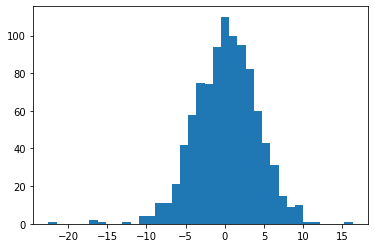

In [16]:
import matplotlib.pyplot as plt
plt.hist(residues, bins = 'auto')

In [17]:
preds, predvar = m.predict_f(Xtest)
RMSE = np.sqrt( ( (Ytest - (meany + stdy*preds.numpy()))**2).mean())
print('RMSE:', RMSE)
#print(preds)

RMSE: 3.99070103350723


In [18]:
print(predvar)

tf.Tensor(
[[0.01598986]
 [0.0307286 ]
 [0.01231428]
 [0.02439989]
 [0.01916008]
 [0.01636661]
 [0.04278649]
 [0.02372569]
 [0.02079154]
 [0.03659235]
 [0.01576223]
 [0.01514651]
 [0.01809988]
 [0.01909326]
 [0.03743717]
 [0.03156514]
 [0.0185463 ]
 [0.07392126]
 [0.01345375]
 [0.02260222]
 [0.01418371]
 [0.02409263]
 [0.02555673]
 [0.02131917]
 [0.01167921]
 [0.03409409]
 [0.03626337]
 [0.06683113]
 [0.01845458]
 [0.01478699]
 [0.01398187]
 [0.02531032]
 [0.01087897]
 [0.02134208]
 [0.02954442]
 [0.01899196]
 [0.01658747]
 [0.02487969]
 [0.02468079]
 [0.01422276]
 [0.0302692 ]
 [0.09402751]
 [0.01296034]
 [0.01769805]
 [0.01648394]
 [0.01887457]
 [0.0161781 ]
 [0.0115543 ]
 [0.03825483]
 [0.02787968]
 [0.01693493]
 [0.0185012 ]
 [0.04485866]
 [0.02471325]
 [0.02383082]
 [0.03053517]
 [0.01740672]
 [0.06569837]
 [0.03490663]
 [0.02279487]
 [0.01242421]
 [0.01774999]
 [0.01461564]
 [0.17006723]
 [0.01211736]
 [0.02743512]
 [0.04035299]
 [0.02190932]
 [0.058846  ]
 [0.04324901]
 [0.01605

In [19]:
preds, predvar = m.predict_f(Xtrain)
RMSE = np.sqrt(   ((stdy*Ytrain - stdy*preds.numpy())**2).mean())
print('RMSE:', RMSE)

RMSE: 4.029616145760007


In [20]:
print(predvar)

tf.Tensor(
[[0.02024877]
 [0.0205723 ]
 [0.02523012]
 ...
 [0.01886903]
 [0.01516149]
 [0.02577919]], shape=(8611, 1), dtype=float64)


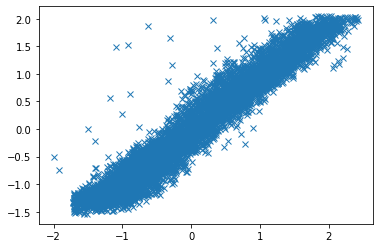

In [21]:
plt.plot(Ytrain, preds, 'x')

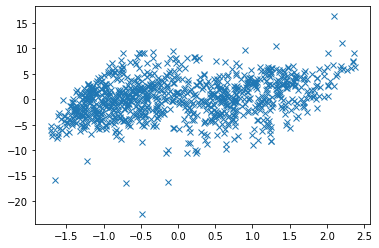

In [22]:
plt.plot((Ytest - meany)/stdy, residues, 'x')

In [23]:
print_summary(m)

╒═════════════════════════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                            │ class            │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                                │
╞═════════════════════════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════════════════════════════╡
│ BezierProcess.likelihood.variance               │ Parameter        │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.06                                                 │
├─────────────────────────────────────────────────┼──────────────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────────────────┤
│ BezierProcess.BN._trainable_weights[0]          │ Res

In [24]:
print(m.BN.meanw)

(<tf.Variable 'Variable:0' shape=(1, 9) dtype=float64, numpy=
array([[-1.26535193,  1.64416845, -0.88812636,  0.61211965,  0.69741535,
        -1.44839824, -1.11940934,  1.42055997,  1.16151106]])>, <tf.Variable 'Variable:0' shape=(9, 9) dtype=float64, numpy=
array([[-1.13415664e-01,  2.04932888e+00,  1.09505287e+00,
        -6.07360891e-01, -5.64768122e-01,  8.99979457e-03,
         7.12523524e-02, -2.94590362e-01,  2.41316370e-02],
       [ 3.38272396e-01, -1.41895403e+00, -1.89576026e+00,
         1.61840496e+00,  2.22083429e+00,  8.03527117e-02,
        -1.67492417e-01,  1.42535871e+00, -5.86069371e-02],
       [-9.37034638e-01,  6.43513642e-01,  8.29298558e-01,
        -1.17618185e+00, -1.00408731e+00, -3.33198261e-01,
         3.70579295e-01, -1.54843318e+00, -1.94964160e-01],
       [ 2.03914863e+00, -4.28108838e-01, -1.73104850e-02,
        -1.83624185e-03,  2.91726887e-01,  1.79841613e+00,
        -7.88670892e-01,  1.04620869e+00,  1.50424807e+00],
       [ 1.33221956e+00, -5.